In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# This AI is trained on events with type 2 only
model_name = 'model-lsr-type2'

shuffle_clusters = False

# load the training data
data = DataModel('data-mtx-top-8-event2.npz', 
                 batch_size = 256, validation_percent = .1, test_percent = .2, 
                 weight_compton=1.5, weight_non_compton=.5)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 1
ai.weight_pos_x = 2.5
ai.weight_pos_y = .5
ai.weight_pos_z = 2
ai.weight_energy = 1
ai.weight_e_cluster = .6
ai.weight_p_cluster = .4

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0000, limbs_l2=.0000)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 60:
        return .003
    elif epoch < 110:
        return .001
    elif epoch < 140:
        return .0003
    elif epoch < 165:
        return .0001
    elif epoch < 185:
        return .00003
    elif epoch < 195:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [5]:
# #LOADING
# ai.load(model_name, optimizer=False)
# ai.compile_model()

In [6]:
#TRAINING

In [7]:
%%time
# start the training
ai.train(epochs=200, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

8018/8018 [==============================] - 15s 2ms/step - loss: 3.0997 - e_cluster_loss: 0.0171 - p_cluster_loss: 0.0823 - type_loss: 0.3130 - pos_x_loss: 0.0657 - pos_y_loss: 2.2694 - pos_z_loss: 0.0433 - energy_loss: 1.3578 - e_cluster__cluster_accuracy: 0.9764 - p_cluster__cluster_accuracy: 0.8752 - type__type_accuracy: 0.8619 - type__type_tp_rate: 0.9156

CPU times: user 4h 9min 23s, sys: 3min 30s, total: 4h 12min 53s
Wall time: 4h 13min 41s


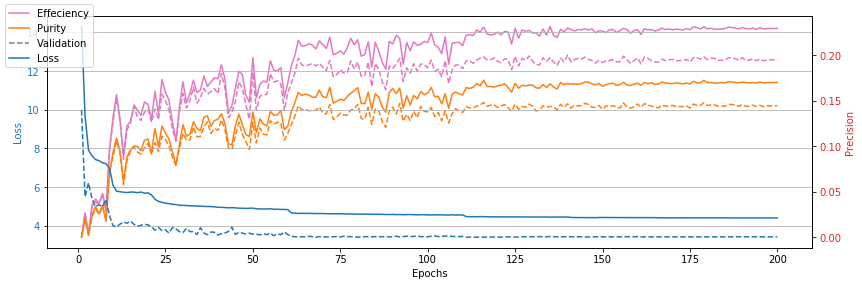

In [8]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [7]:
# evaluation only on type2 events
ai.evaluate()

AI model
  Loss:        3.44624
    -Type:         0.33597 *  1.00 = 0.33597
    -Pos X:        0.06591 *  2.50 = 0.16479
    -Pos Y:        2.30957 *  0.50 = 1.15479
    -Pos Z:        0.04927 *  2.00 = 0.09855
    -Energy:       1.61401 *  1.00 = 1.61401
    -Cls e:        0.05562 *  0.60 = 0.03337
    -Cls p:        0.11190 *  0.40 = 0.04476
  Accuracy:     0.85457
    -Precision:    0.66954
    -Recall:       0.89701
    -Cls e rate:   0.94978
    -Cls p rate:   0.84905
  Efficiency:   0.19124
  Purity:       0.14274
  Euc mean:    11.31540
  Euc std:     21.13712
  Energy mean:  0.34725
  Energy std:   0.77705

Reco
  Accuracy:     0.65765
    -TP rate:      0.37863
  Efficiency:   0.05743
  Purity:       0.05512
  Euc mean:    20.59427
  Euc std:     43.39594
  Energy mean:  0.58238
  Energy std:   1.08856


In [9]:
# evaluate the AI on the test dataset
ai.data = DataModel('data-mtx-top-8.npz', 
                    batch_size = 128, validation_percent = .1, test_percent = .2)
ai.evaluate()

AI model
  Loss:        2.34492
    -Type:         0.65269 *  1.00 = 0.65269
    -Pos X:        0.03580 *  2.50 = 0.08950
    -Pos Y:        1.25701 *  0.50 = 0.62850
    -Pos Z:        0.02670 *  2.00 = 0.05341
    -Energy:       0.87827 *  1.00 = 0.87827
    -Cls e:        0.03029 *  0.60 = 0.01817
    -Cls p:        0.06093 *  0.40 = 0.02437
  Accuracy:     0.69498
    -Precision:    0.30972
    -Recall:       0.89702
    -Cls e rate:   0.94982
    -Cls p rate:   0.84905
  Efficiency:   0.19125
  Purity:       0.06604
  Euc mean:    11.31234
  Euc std:     21.13538
  Energy mean:  0.34719
  Energy std:   0.77704

Reco
  Accuracy:     0.69118
    -TP rate:      0.37851
  Efficiency:   0.05745
  Purity:       0.03047
  Euc mean:    20.59387
  Euc std:     43.40493
  Energy mean:  0.58215
  Energy std:   1.08863


In [10]:
# save the trained model
ai.save(file_name=model_name)